# ARIMA Modelling 

Start Date: 5/6/2024
End Date:


**Steps:**

1. Load data
2. Plot data
3. Check stationary:
> - Transform to stationary using differencing, decide for parameter d
> - Plot ACF and PACF to decide for parameter p and q
5. Data is split into Train-Test-Set (interchangeable with either step 3 or 5)
6. Using auto-arima for auto parameter
7. Train model
8. Prediction on test set
9. Evaluate using metrics and plotting
10. Choosing hyperparameter to lessen the error??
11. Future dates prediction reading


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Read the data

In [30]:
df2=pd.read_csv('data/household_power_consumption_cleaned_datetime_index_drop_intensity.csv')
df2.head()

,DateTime,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2007-01-01 00:00:00,2.580,0.136,241.97,0.0,0.0,0.0
1,2007-01-01 00:01:00,2.552,0.100,241.75,0.0,0.0,0.0
2,2007-01-01 00:02:00,2.550,0.100,241.64,0.0,0.0,0.0
3,2007-01-01 00:03:00,2.550,0.100,241.71,0.0,0.0,0.0
4,2007-01-01 00:04:00,2.554,0.100,241.98,0.0,0.0,0.0


In [31]:
# Set the datetime column as the index
df2.set_index('DateTime', inplace=True)
df2.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,0.0,0.0,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,0.0,0.0,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,0.0,0.0,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,0.0,0.0,0.0
2007-01-01 00:04:00,2.554,0.100,241.98,0.0,0.0,0.0


In [32]:
# Ensure the index is a DatetimeIndex
df2.index = pd.to_datetime(df2.index)

In [33]:
df = df2[['Global_active_power']].copy()
df.head()
#The copy() method is used to ensure that the new DataFrame is independent of the original DataFrame 
#and any changes made to it won't affect the original DataFrame.

,Global_active_power
DateTime,
2007-01-01 00:00:00,2.580
2007-01-01 00:01:00,2.552
2007-01-01 00:02:00,2.550
2007-01-01 00:03:00,2.550
2007-01-01 00:04:00,2.554


In [34]:
df.tail()

,Global_active_power
DateTime,
2007-06-30 23:55:00,2.880
2007-06-30 23:56:00,2.892
2007-06-30 23:57:00,2.882
2007-06-30 23:58:00,2.660
2007-06-30 23:59:00,2.548


In [35]:
df.dtypes

Global_active_power    float64
dtype: object

In [36]:
# Convert DataFrame to CSV
df.to_csv('arima_model_dataset.csv', index=True)

In [37]:
if df['Global_active_power'].isnull().any():
    print("There are NaN values in the 'Global_active_power' column.")
else:
    print("There are no NaN values in the 'Global_active_power' column.")

There are no NaN values in the 'Global_active_power' column.


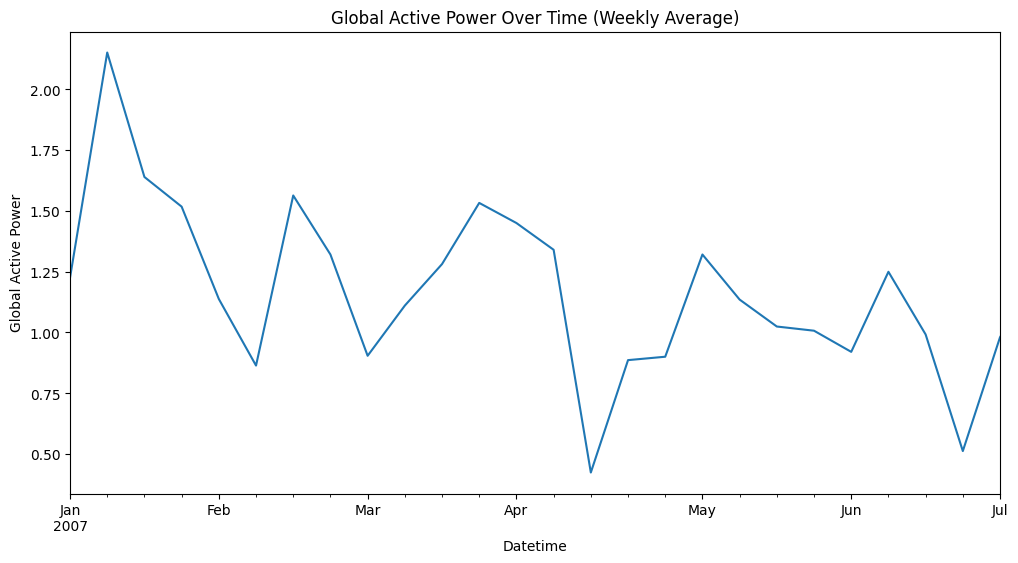

In [38]:
df.index = pd.to_datetime(df.index)
# Resample the data to daily frequency and calculate the mean
df_resampled = df['Global_active_power'].resample('W').mean()

# Plot the resampled data
plt.figure(figsize=(12, 6))
df_resampled.plot(kind='line')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power')
plt.title('Global Active Power Over Time (Weekly Average)')

# Set the x-axis limits to display dates until 30/06/2007
plt.xlim(df_resampled.index.min(), pd.Timestamp('2007-06-30'))

plt.show()

**A) The dataset will be resampled to weekly frequency**

Aggregating to Lower Frequency: 
  
- If your original data is at a high frequency (e.g., daily or hourly), aggregate it to a lower frequency (e.g., weekly or monthly) by computing summary statistics (e.g., sum, mean) over each interval. This reduces the number of data points while preserving the overall trends and patterns in the data.

In [39]:
df.index = pd.to_datetime(df.index)

#resample the dataset
agg_df = df.resample('W').sum()  # Aggregate data to weekly frequency by summing values
agg_df.head()

,Global_active_power
DateTime,
2007-01-07,10587.220937
2007-01-14,6195.794937
2007-01-21,16525.666000
2007-01-28,15295.744937
2007-02-04,11467.652000


### Starting here our the dataframe use for modelling is : `agg_df`

## 2. Plot the data to check for variance and trend

i) Plotting original dataframe without resampling

(13514.0, 13694.0)

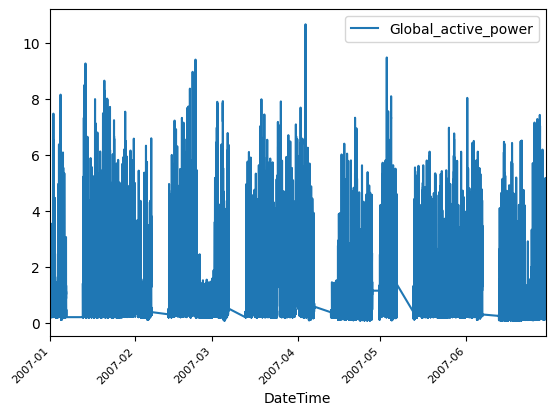

In [40]:
# Plot the data
df.plot()
plt.xticks(rotation=45, fontsize=8, ha='right')  # for easy readability
# Set the x-axis limits to display dates until 30/06/2007
plt.xlim(df.index.min(), '2007-06-30')
# Show the plot
#plt.show()

ii) Plotting resampled dataframe 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 2007-01-07 to 2007-12-09
Freq: W-SUN
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Global_active_power  49 non-null     float64
dtypes: float64(1)
memory usage: 784.0 bytes


(1932.0, 1957.0)

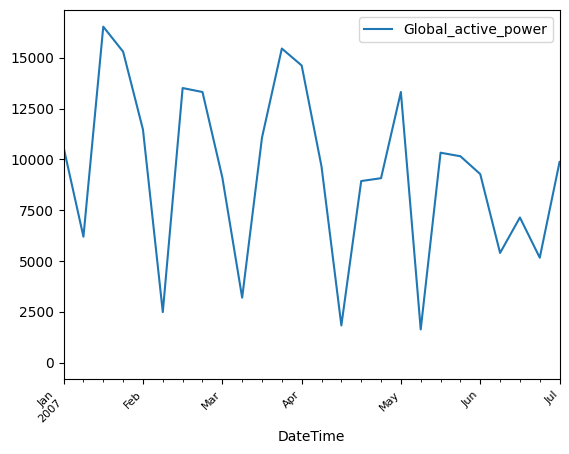

In [41]:
agg_df.info()

agg_df.plot()
plt.xticks(rotation=45, fontsize=8, ha='right')
plt.xlim(df.index.min(), '2007-06-30')#for easy readability
#plt.xticks(45)

iii) Plotting to see the seasonal patternof time series

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

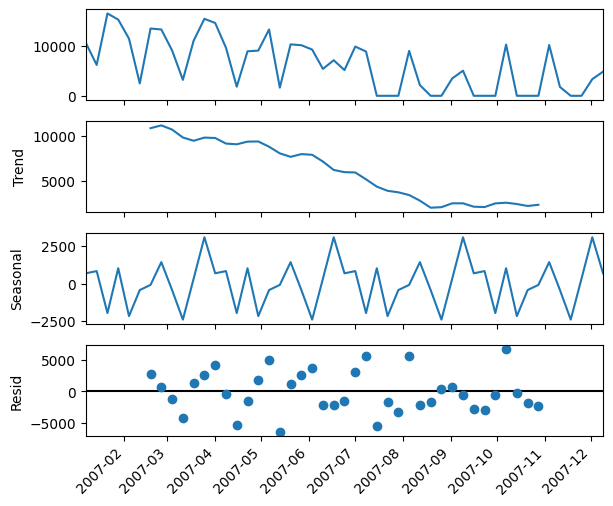

In [43]:
model = seasonal_decompose(agg_df,model='additive',period=12)  #this is how it will look when we lessen the time records,more neat

fig = model.plot()

# Rotate the x-axis labels
for ax in fig.axes:  # Iterate through the axes in the figure
    plt.sca(ax)
    plt.xticks(rotation=45, ha='right')

plt.show()
#https://blog.devops.dev/lets-talk-about-your-first-arima-model-cbfdcba1749e

# 3. Check for stationarity of time series

**i) Check the stationarity**

**Methods to check on stationarity of the time series**
1. Method 1: time series plot
2. Method 2: ACF plot and PACF plot
3. Method 3: ADF test (Augmented Dickey-Fuller test)
    
- Transform
- Cross-check

**Method 1: time series plot**

if there is upper and downward trend , it is not stationary

**Method 2: ACF plot and PACF plot**

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

- As our dataframe is **agg_df**

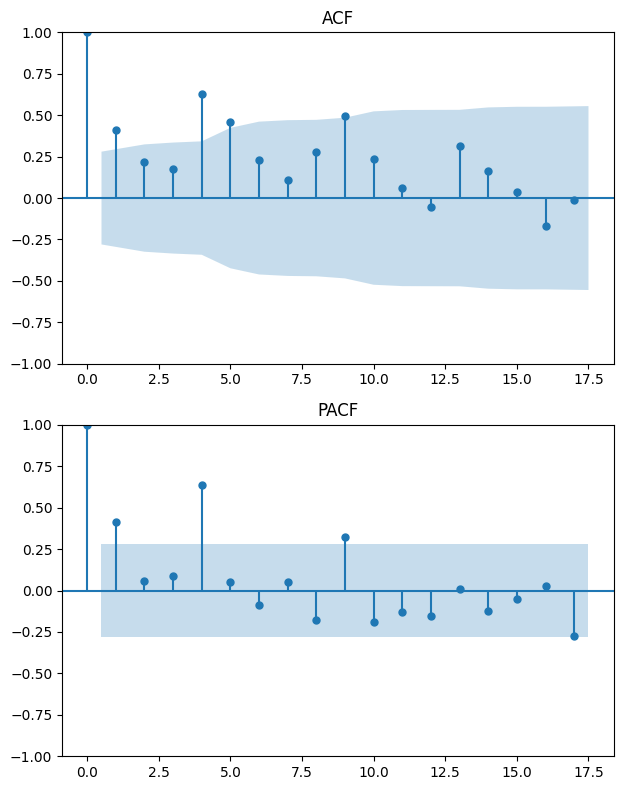

In [45]:
#active_series = df['Global_active_power']

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF
plot_acf(agg_df, ax=ax[0, 0])
ax[0, 0].set_title('ACF')

# Plot PACF
plot_pacf(agg_df, ax=ax[1, 0])
ax[1, 0].set_title('PACF')

# Remove empty subplot
fig.delaxes(ax[0, 1])
fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

<details>
  <summary>Why my ACF and PACF blue dense area is so small</summary>
  
  If the blue dense part of your ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots appears small, it could be due to a few reasons:

1. **Sample Size**: If your dataset is small, the number of lags considered for the ACF and PACF plots may be limited. This can result in a smaller blue region, indicating fewer available lags for correlation analysis.

2. **Lag Selection**: The size of the blue region depends on the number of lags considered for the plots. If you have a large dataset but are only plotting a small number of lags, the blue region may appear small.

3. **Correlation Magnitude**: The height of the bars in the ACF and PACF plots represents the magnitude of correlation. If the correlations are weak overall, the bars may be short, leading to a smaller blue region.

4. **Statistical Significance**: The blue region represents the confidence interval for the correlations. If the correlations are not statistically significant, the blue region may be narrow, indicating less certainty about the correlation values.

To address this issue:

- **Increase Sample Size**: If possible, collect more data to increase the sample size and provide more information for the ACF and PACF analysis.

- **Adjust Lag Selection**: Increase the number of lags considered for the plots to include more data points and potentially expand the blue region.

- **Evaluate Correlation Magnitude**: Assess the magnitude of correlations in your data. If correlations are weak, consider whether your data truly exhibits autocorrelation patterns.

- **Consider Statistical Significance**: Ensure that the correlations observed in your data are statistically significant. Narrow blue regions may indicate that correlations are not significant.

By considering these factors, you can better interpret the ACF and PACF plots and understand the autocorrelation patterns in your data. If you're still unsure about the interpretation, it may be helpful to consult with a statistician or data analyst for further guidance.
</details>

From **ACF** and **PACF** plot, we see our data is (both for original and train which is original too no?)
- ACF has decay plot gradually
- while PACF has significant spike 
- this show our model is ARIMA(p,d,0)

#okay have to check back

ACF nampak turun kat 3?

**Method 3: ADF test (Augmented Dickey-Fuller test)**

In [46]:
from statsmodels.tsa.stattools import adfuller
#adf_test = adfuller(df_train)
#print(f'p-value: {adf_test[1]}')
#this is for one-dimensional array
#The error you're seeing with the adfuller function is due to the same issue: it expects a one-dimensional array, 
#but you are providing a two-dimensional DataFrame. 
#You need to pass a specific column of your DataFrame to the function

In [47]:
adf_test_1 = adfuller(agg_df)

# Print the p-value
print(f'p-value: {adf_test_1[1]}')

p-value: 0.835502442257712


In [48]:
##creating a function for values 
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
       print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

adf_test(agg_df['Global_active_power']) 

1. ADF :  -0.7422421490631622
2. P-Value :  0.835502
3. Num Of Lags :  8
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 40
5. Critical Values :
	 1% :  -3.6055648906249997
	 5% :  -2.937069375
	 10% :  -2.606985625
Failed to Reject Ho - Time Series is Non-Stationary


<details>
  <summary>What the p-value tell us is: (click to expand)</summary>
  
A p-value of 0.0 (or very close to zero) from the Augmented Dickey-Fuller (ADF) test, indicates that the null hypothesis of the test (which states that the series has a unit root and is non-stationary) can be rejected with high confidence. **Therefore, a p-value of 0.0 suggests that data is indeed stationary.**

Here's a more detailed explanation:
    
Null Hypothesis (H0): The time series has a unit root (i.e., it is non-stationary).
    
Alternative Hypothesis (H1): The time series does not have a unit root (i.e., it is stationary).
    
When the p-value is very low (typically below a threshold such as 0.05), reject the null hypothesis.
    
</details>


**ii) Transform the time-series to stationary**

- Transform time-series to stationary by differencing

**iii) Cross-check after transform**

Check the p-value after differencing, if p-value is still high, make a differencing on the diff_series,and repeat ADF test

In [50]:
#Now lets check the p-value after differencing
##creating a function for values 
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", round(dftest[1],6))
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
       print("\t",key, ": ", val)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

adf_test(df_diff['Global_active_power']) 

#from https://blog.devops.dev/lets-talk-about-your-first-arima-model-cbfdcba1749e

1. ADF :  -4.234673605098992
2. P-Value :  0.000575
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 40
5. Critical Values :
	 1% :  -3.6055648906249997
	 5% :  -2.937069375
	 10% :  -2.606985625
Reject Ho - Time Series is Stationary


In [51]:
adf_test_2 = adfuller(df_diff)

# Print the p-value
print(f'p-value: {adf_test_2[1]}')  #slicing to extract only second value for that adfuller method

p-value: 0.0005752940973863075


<Axes: xlabel='DateTime'>

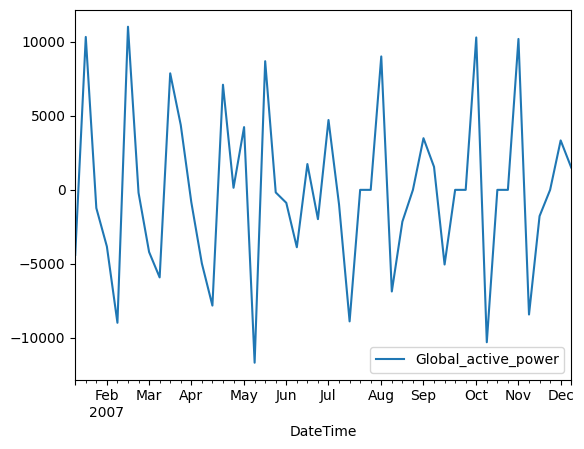

In [49]:
df_diff = agg_df.diff().dropna()
df_diff.plot()

### Starting from here our dataframe is `df_diff`

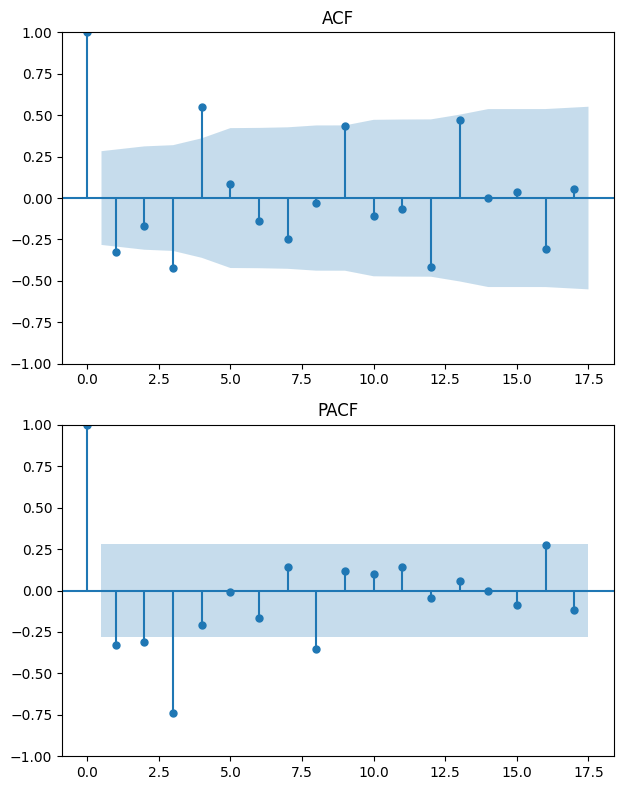

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF
plot_acf(df_diff, ax=ax[0, 0])
ax[0, 0].set_title('ACF')

# Plot PACF
plot_pacf(df_diff, ax=ax[1, 0])
ax[1, 0].set_title('PACF')

# Remove empty subplot
fig.delaxes(ax[0, 1])
fig.delaxes(ax[1, 1])

plt.tight_layout()
plt.show()

as we differencing once to achieve the p-value smaller than 0.05 as to make our dataset is stationary, our parameter for **d = 1**

## 4. Split Data to Train-Test-Split

In [53]:
#msk = (df.index < len(df)-30)  or #msk = df.index < (len(df) - 30) ## Create a mask for the training set
#df_train = df[msk].copy()
#df_test = df[~msk].copy()
#tak boleh sebab datetime in index, kena guna proper slicing

In [54]:
# Use the last 30 entries as the test set, and the rest as the training set
# Split the data into training and test sets based on the last 30 entries
#df_train = df.iloc[:-30].copy()  #30 terakhir tu sebagai test set
#df_test = df.iloc[-30:].copy()   #30 tu la test set, the rest are train
df_train = df_diff.iloc[:-30].copy()  #30 terakhir tu sebagai test set
df_test = df_diff.iloc[-30:].copy()   #30 tu la test set, the rest are train

ACF and PACF for df_train


<details>
  <summary>acf pacf plot for train set multi-column</summary>
    
```  #acf_original = plot_acf(df_train)
#pacf_original = plot_pacf(df_train)
#function expect a one-dimensional array, but df with a two-dimensional DataFrame.

# Select the 'Global_active_power' column for training data
train_series = df_train['Global_active_power']

# Plot the ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
acf_original = plot_acf(train_series, ax=ax[0])
pacf_original = plot_pacf(train_series, ax=ax[1])
plt.show()

#where is the backdrop yang range tu? nak tengok go beyond ka dak spike tu
```
</details>

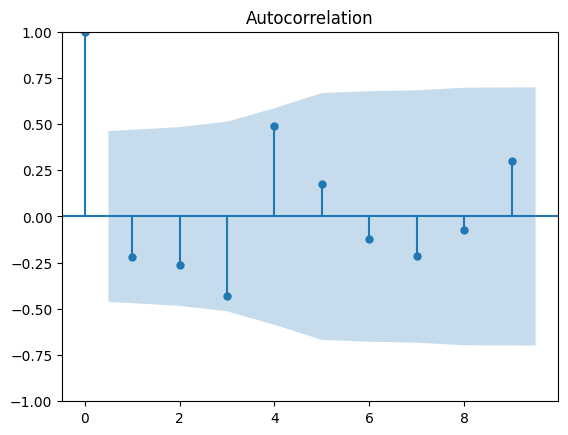

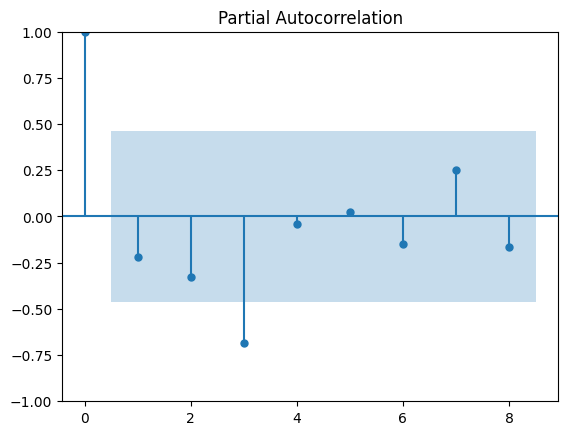

In [55]:
acf_original = plot_acf(df_train)
#pacf_original = plot_pacf(df_train)
#ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 13 must be < 9.
# Assuming 'df_train' is your DataFrame with datetime index
pacf_original = plot_pacf(df_train, lags=8)  # Specify fewer lags, e.g., 9 kena kecik dari 9
#function expect a one-dimensional array, but df with a two-dimensional DataFrame.
# Plot the ACF and PACF
#fig, ax = plt.subplots(2, 1, figsize=(12, 8))
#acf_original = plot_acf(train_series, ax=ax[0])
#pacf_original = plot_pacf(train_series, ax=ax[1])
#plt.show()

#just to check,samadengan df_diff tak

# 5. Choosing parameter using auto_arima

## Manual
from acf and pacf model off df_diff
p=1
q=0
sebab ARIMA(p,d,0)
d=1
q=0
p=?
i cannot do this,cannot read the plot

<details>
  <summary>Here's how to determine p and q:</summary>
  
Identify p (AR component):

Check ACF plot for significant drop in autocorrelation values or first crossing of confidence interval.
Lag before drop indicates p.

Identify q (MA component):

Check PACF plot for significant drop in partial autocorrelation values or first crossing of confidence interval.
Lag before drop indicates q.

evaluate the model's performance using techniques such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to select the best model.
</details>




## Auto
1. auto_arima without considering AIC
2. auto_arima with purpose to minimize AIC error

In [56]:
import pmdarima as pm
from pmdarima import auto_arima
from pmdarima.arima import auto_arima

In [57]:
parameter_1 = auto_arima(agg_df['Global_active_power'], 
                          suppress_warnings=True)           

parameter_1.summary()
#the reason we use agg_df as this df is not yet differenced so that it is not stationary yet
#we do not use df_diff and df_train as both has already differenced

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(3, 1, 1)   Log Likelihood                -461.370
Date:                Wed, 19 Jun 2024   AIC                            932.739
Time:                        22:33:32   BIC                            942.095
Sample:                    01-07-2007   HQIC                           936.275
                         - 12-09-2007                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5020      0.106     -4.723      0.000      -0.710      -0.294
ar.L2         -0.4917      0.108     -4.544      0.000      -0.704      -0.280
ar.L3         -0.6840      0.094     -7.264      0.000      -0.869      -0.499
ma.L1         -0.3279      0.182     -1.802      0.072      -0.685       0.029
sigma2      1.075e+07   7.16e-09    1.5e+15      0.000    1.08e+07    1.08e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.46   Prob(JB):                         0.50
Heteroskedasticity (H):               0.33   Skew:                             0.36
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+31. Standard errors may be unstable.
"""

collapse

auto_arima = pm.auto_arima(agg_df, stepwise=False, seasonal=False) #use df before diff and train,so it detects that it need to diff
auto_arima
auto_arima.summary()

#cannot run on df_diff as it already stationary, the auto will give d=0
#cannot run on df_train(df_train = df_diff yg dirain), same issue,it deems d=0

**1. Auto_arima without considering AIC give out ARIMA(3,1,1)**

What if we try to use AIC to evaluate what arima model is the best for our model,and compare this two model

In [58]:
## Auto Arima


model = auto_arima(df_train, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=1,             
                      d=1,     ## we know our d is 1     
                      seasonal=False,   
                      start_P=0, 
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=357.453, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=365.604, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=363.911, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=363.664, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=359.216, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=365.049, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=355.604, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=361.755, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1

**2. auto_arima considering AIC: Best model:  ARIMA(1,1,1)(0,0,0)[0]**

# 5. Fit the ARIMA model to data

**1. Model 1 :ARIMA(3,1,1)**

In [59]:
#model Training for Model 1
arima_1 = ARIMA(df_train['Global_active_power'],order=(3,1,1)) ## p,d,q

model_1 = arima_1.fit()
model_1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   18
Model:                  ARIMA(3, 1, 1)   Log Likelihood                -166.920
Date:                 Wed, 19 Jun 2024   AIC                            343.840
Time:                         22:33:35   BIC                            348.006
Sample:                     01-14-2007   HQIC                           344.254
                          - 05-13-2007                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6410      0.376     -1.705      0.088      -1.378       0.096
ar.L2         -0.5230      0.292     -1.793      0.073      -1.095       0.049
ar.L3         -0.8174      0.294     -2.782      0.005      -1.393      -0.241
ma.L1         -0.8502      0.537     -1.582      0.114      -1.903       0.203
sigma2      2.416e+07   1.07e-08   2.25e+15      0.000    2.42e+07    2.42e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 1.16
Prob(Q):                              0.76   Prob(JB):                         0.56
Heteroskedasticity (H):               1.47   Skew:                            -0.58
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.76e+31. Standard errors may be unstable.
"""

**2. Model 2 :ARIMA(1,1,1)**

In [60]:
#model Training for Model 2
arima_2 = ARIMA(df_train['Global_active_power'],order=(1,1,1)) ## p,d,q

model_2 = arima_2.fit()
model_2.summary() 

C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                
===============================================================================
Dep. Variable:     Global_active_power   No. Observations:                   18
Model:                  ARIMA(1, 1, 1)   Log Likelihood                -174.802
Date:                 Wed, 19 Jun 2024   AIC                            355.604
Time:                         22:33:35   BIC                            358.104
Sample:                     01-14-2007   HQIC                           355.853
                          - 05-13-2007                                         
Covariance Type:                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2291      0.480     -0.478      0.633      -1.169       0.711
ma.L1         -0.9590      0.960     -0.998      0.318      -2.841       0.923
sigma2      5.556e+07   2.09e-08   2.65e+15      0.000    5.56e+07    5.56e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 1.24
Prob(Q):                              0.81   Prob(JB):                         0.54
Heteroskedasticity (H):               0.90   Skew:                            -0.02
Prob(H) (two-sided):                  0.90   Kurtosis:                         1.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.68e+31. Standard errors may be unstable.
"""

# 7. Make predictions on Test Set

**1. Model 1**

<Axes: xlabel='DateTime'>

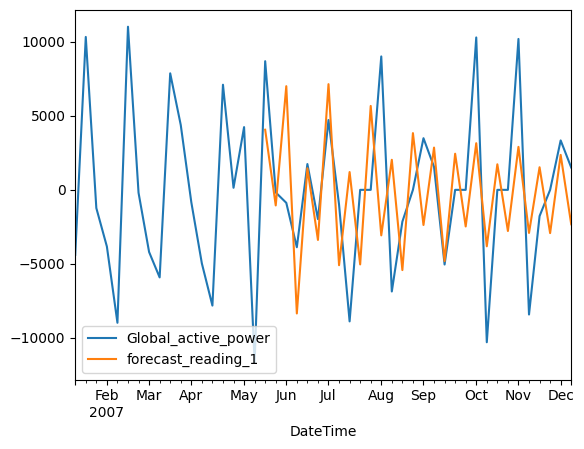

In [61]:
forecast_test = model_1.forecast(len(df_test))

df_diff['forecast_reading_1'] = [None]*len(df_train) + list(forecast_test)

df_diff.plot()

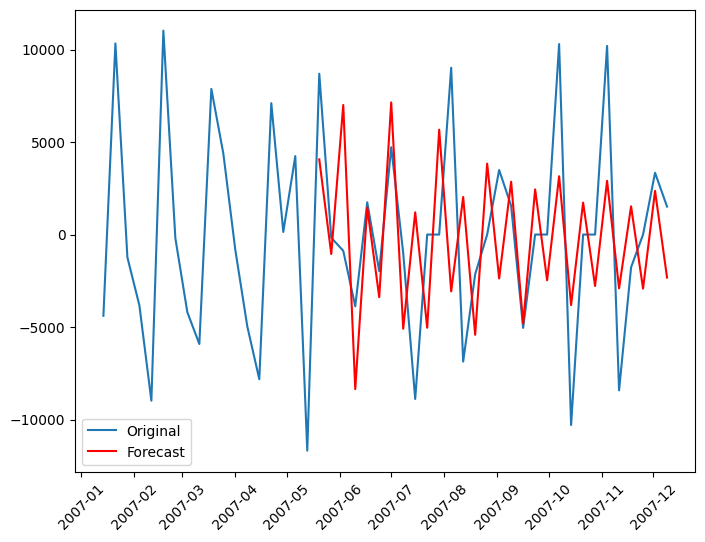

In [62]:
forecast_test_1 = model_1.forecast(len(df_test))
# Create a new DataFrame to store the forecast
df_forecast = df_test.copy()
df_forecast['forecast_auto_1'] = forecast_test_1

# Combine the original and forecasted data for plotting
df_combined = pd.concat([df_train, df_forecast], axis=0)

#agg_df['forecast_manual'] = [None]*len(df_train) + list(forecast_test_1)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(df_combined['Global_active_power'], label='Original')
plt.plot(df_combined['forecast_auto_1'], label='Forecast', color='red')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#agg_df.plot()

C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='DateTime'>

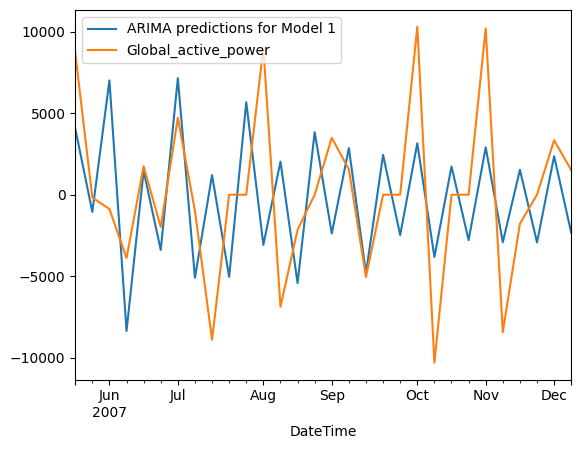

In [63]:
start = len(df_train)
end = len(df_train)+len(df_test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
#index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred = model_1.predict(start=start,end=end,typ='levels').rename('ARIMA predictions for Model 1')
#pred.index=index_future_dates
pred.plot(legend=True)

df_test['Global_active_power'].plot(legend=True) 

## NEXT

**1. Model 2**

<Axes: xlabel='DateTime'>

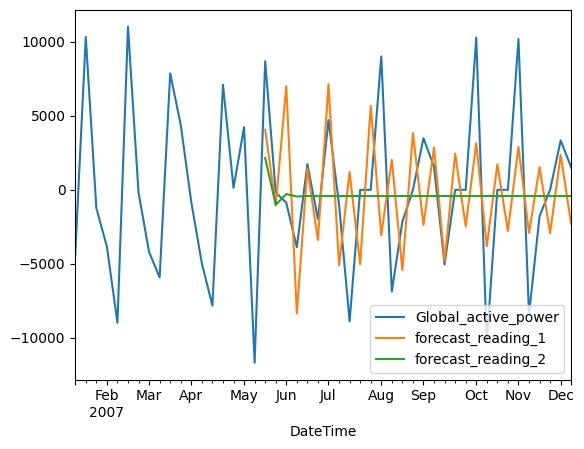

In [64]:
forecast_test_2 = model_2.forecast(len(df_test))

df_diff['forecast_reading_2'] = [None]*len(df_train) + list(forecast_test_2)

df_diff.plot()

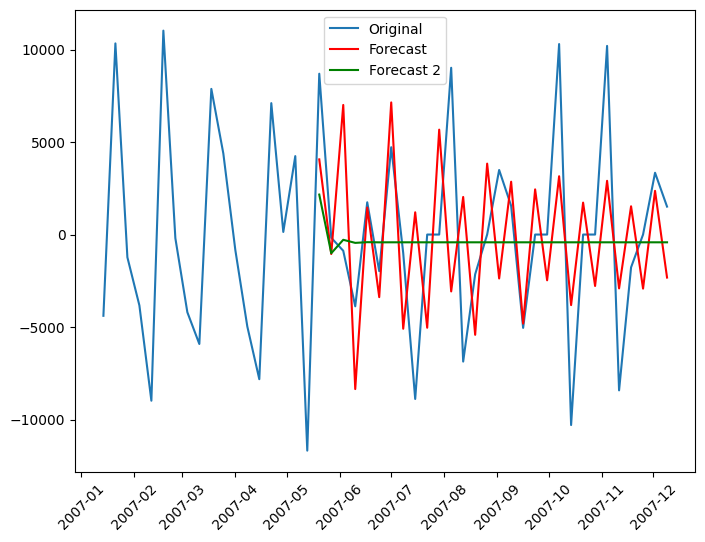

In [65]:
forecast_test_1 = model_1.forecast(len(df_test))
# Create a new DataFrame to store the forecast
df_forecast = df_test.copy()
df_forecast['forecast_auto_1'] = forecast_test_1

# Combine the original and forecasted data for plotting
df_combined = pd.concat([df_train, df_forecast], axis=0)

forecast_test_2 = model_2.forecast(len(df_test))
# Create a new DataFrame to store the forecast
df_forecast_2 = df_test.copy()
df_forecast_2['forecast_auto_2'] = forecast_test_2

# Combine the original and forecasted data for plotting
df_2_combined = pd.concat([df_train, df_forecast_2], axis=0)

#agg_df['forecast_manual'] = [None]*len(df_train) + list(forecast_test_1)

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(df_combined['Global_active_power'], label='Original')
plt.plot(df_combined['forecast_auto_1'], label='Forecast', color='red')
plt.plot(df_2_combined['forecast_auto_2'], label='Forecast 2', color='green')
plt.legend()
plt.xticks(rotation=45)
plt.show()

#agg_df.plot()

C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='DateTime'>

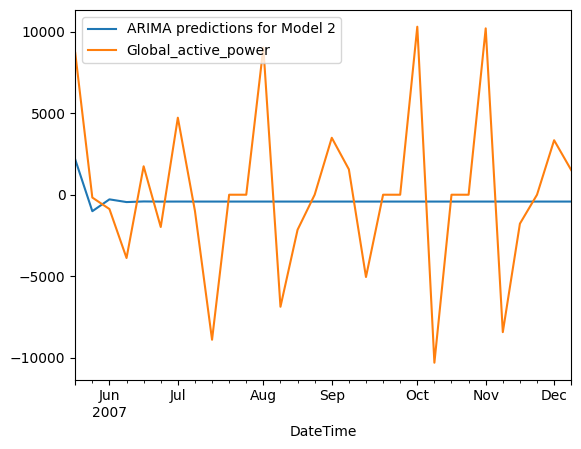

In [66]:
start = len(df_train)
end = len(df_train)+len(df_test)-1
#if the predicted values dont have date values as index, you will have to uncomment the following two commented lines to plot a graph
#index_future_dates=pd.date_range(start='2018-12-01',end='2018-12-30')
pred = model_2.predict(start=start,end=end,typ='levels').rename('ARIMA predictions for Model 2')
#pred.index=index_future_dates
pred.plot(legend=True)

df_test['Global_active_power'].plot(legend=True) 

## 8. Evaluate the model

**Model 1: ARIMA(3,1,1)**

In [67]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
#for model 1
mae = mean_absolute_error(df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test))

print(f'mae - Model 1: {mae}')
print(f'mape - Model 1: {mape}')
print(f'rmse - Model 1: {rmse}')

mae - Model 1: 4307.40961106076
mape - Model 1: 4.0348164561994076e+18
rmse - Model 1: 5194.410724759359


**Model 2: ARIMA(1,1,1)**

In [68]:
#for model 2
mae = mean_absolute_error(df_test, forecast_test_2)
mape = mean_absolute_percentage_error(df_test, forecast_test_2)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_2))

print(f'mae - Model 2: {mae}')
print(f'mape - Model 2: {mape}')
print(f'rmse - Model 2: {rmse}')

mae - Model 2: 3566.49952930759
mape - Model 2: 5.035606364539369e+17
rmse - Model 2: 4983.576468477991


Evaluation of Current Model
Given the current model, here are some steps to evaluate its performance and suitability:

Compare with Baselines: Evaluate model against simple baselines like the naive forecast, simple moving average, and mean forecast.
Check Residuals: Analyze the residuals (errors) of model to check for patterns. If there are patterns, model may be missing key aspects of the data (e.g., seasonality).( i found one in the tutorial,maybe need to revisit)
Cross-Validation: Use time-series cross-validation methods to ensure model generalizes well to unseen data.

### overall view

if combine index, sort,loc

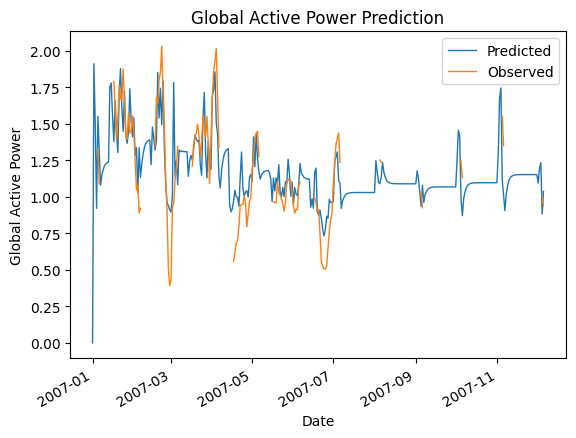

In [69]:
act_power_df = df['Global_active_power']
#df_filtered = df.set_index(pd.to_datetime(df.index)).sort_index().loc[:'2007-08'] 
# Group by the datetime index and calculate the mean of 'Global_active_power'
df_resampled = act_power_df.resample('D').mean()  # Resampling to daily frequency and calculating mean


model = ARIMA(df_resampled, order=(3,1,1))  # Initializing ARIMA model
fitted_model = model.fit()  # Fitting the model to the resampled data
predictions = fitted_model.predict()  # Making predictions

plt.plot(predictions, linewidth=1)  # Plotting predicted values
df_resampled.rolling(5).mean().plot(linewidth=1)  # Plotting observed values with a rolling mean
plt.legend(['Predicted', 'Observed'])
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.title('Global Active Power Prediction')
plt.show()

## 9. For future readings

C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-

<Axes: >

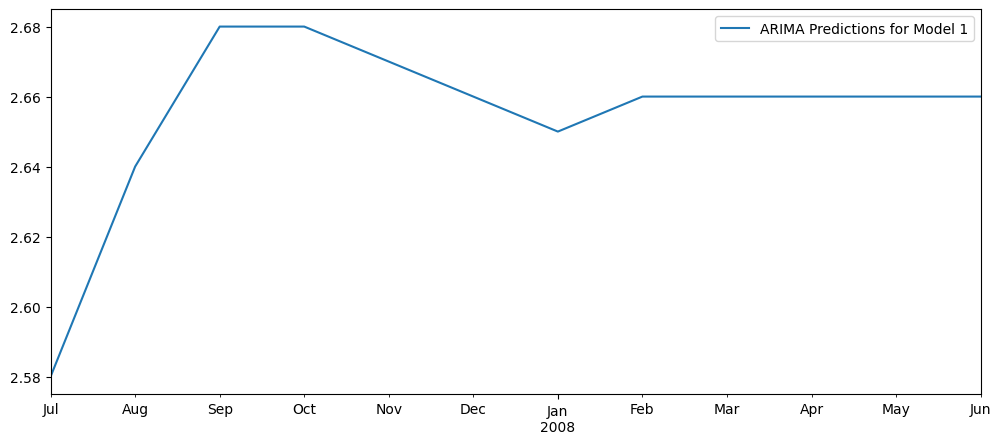

In [70]:
# Fitting the entire data
ARIMA_1 = ARIMA(df['Global_active_power'], order=(3, 1, 1))
model_1 = ARIMA_1.fit()

# Generating index for future dates (next 12 months)
index_future_dates = pd.date_range(start='2007-07-01', end='2008-06-01', freq='MS')

# Predicting for the next 12 months
pred = model_1.predict(start=len(df), end=len(df) + 11, typ='levels').rename('ARIMA Predictions for Model 1')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates

# Plotting prediction
pred.plot(figsize=(12, 5), legend=True)


In [71]:
#index_future_dates=pd.date_range(start='2007-07-01', end='2008-06-30')
#print(index_future_dates)
#pred=model_1.predict(start=len(df),end=len(df)+11,typ='levels').rename('ARIMA Predictions for Model 1')
#print(comp_pred)
#pred.index=index_future_dates
#print(pred)

index_future_dates = pd.date_range(start='2007-07-01', end='2008-06-01', freq='MS')

# Predicting for the next 12 months
pred = model_1.predict(start=len(df), end=len(df) + 11, typ='levels').rename('ARIMA Predictions for Model 1')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates[:len(pred)]  # Adjusting the length of the index
print(pred)

2007-07-01    2.58
2007-08-01    2.64
2007-09-01    2.68
2007-10-01    2.68
2007-11-01    2.67
2007-12-01    2.66
2008-01-01    2.65
2008-02-01    2.66
2008-03-01    2.66
2008-04-01    2.66
2008-05-01    2.66
2008-06-01    2.66
Freq: MS, Name: ARIMA Predictions for Model 1, dtype: float64


C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\najib\anaconda3\Lib\site-

<Axes: >

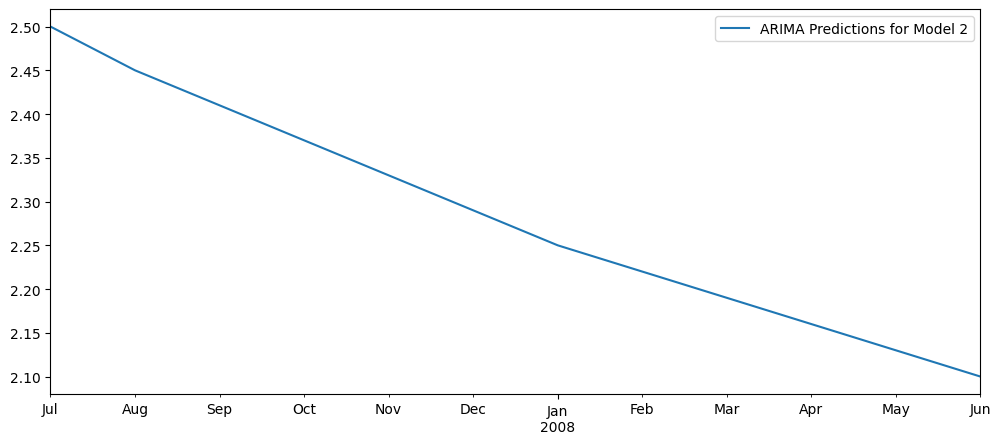

In [72]:
# Fitting the entire data
ARIMA_2 = ARIMA(df['Global_active_power'], order=(1, 1, 1))
model_2 = ARIMA_2.fit()

# Generating index for future dates (next 12 months)
index_future_dates = pd.date_range(start='2007-07-01', end='2008-06-30', freq='MS')

# Predicting for the next 12 months
pred = model_2.predict(start=len(df), end=len(df) + 11, typ='levels').rename('ARIMA Predictions for Model 2')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates

# Plotting prediction
pred.plot(figsize=(12, 5), legend=True)
#1 minute run

In [73]:
index_future_dates = pd.date_range(start='2007-07-01', end='2008-06-01', freq='MS')

# Predicting for the next 12 months
pred = model_2.predict(start=len(df), end=len(df) + 11, typ='levels').rename('ARIMA Predictions for Model 2')
pred = round(pred, 2)

# Assigning the index to the predictions
pred.index = index_future_dates[:len(pred)]  # Adjusting the length of the index
print(pred)

2007-07-01    2.50
2007-08-01    2.45
2007-09-01    2.41
2007-10-01    2.37
2007-11-01    2.33
2007-12-01    2.29
2008-01-01    2.25
2008-02-01    2.22
2008-03-01    2.19
2008-04-01    2.16
2008-05-01    2.13
2008-06-01    2.10
Freq: MS, Name: ARIMA Predictions for Model 2, dtype: float64


C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\najib\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


ref

https://www.youtube.com/watch?v=-aCF0_wfVwY
https://www.youtube.com/watch?v=-_2wOrEuFaM

will not use this but anyway https://www.youtube.com/watch?v=8FCDpFhd1zk&t=488s

https://www.geeksforgeeks.org/time-series-analysis-and-forecasting/

https://medium.com/@wainaina.pierre/the-complete-guide-to-time-series-forecasting-models-ef9c8cd40037

https://github.com/nachi-hebbar/ARIMA-Temperature_Forecasting/blob/master/Temperature_Forecast_ARIMA.ipynb
https://blog.devops.dev/lets-talk-about-your-first-arima-model-cbfdcba1749e
https://itsudit.medium.com/deciphering-acf-and-pacf-plots-a-guide-to-time-series-forecasting-3323948935fb
https://archive.ph/6Qqfr  https://archive.ph/OELYB

My error is high, need to find 